In [137]:
folder = "irb/722"
SESSION_ID = "CHI2019"

# Overview

Specify a data folder. Run all the cleaning functions. 
Using the cleaning routine, you need to determine the start and end of activity manually.
Once clean, we can process the EDA data and extract phasic and SMNA data. 

In [138]:
import json, os, csv, platform, datetime, time, copy
from glob import glob
import numpy as np
from pprint import pprint
from matplotlib import pyplot as pl
import pandas as pd

DATA_ROOT = "irb"

E4_MANIFEST = {
    'phasic': {
        'name': "Phasic GSR",
        'description': "Event-specific EDA"
    },
    'smna':{
        'name': "SMNA",
        'description': "sparse SMNA driver of phasic component"
    },
    'textchunk': {
        'name': "Text Chunk",
        'description': "Values correspond to typing behaviors.  # of consecutive characters typed."
    },
    'temp': {
        'name': "Temperature",
        'description': "Data from temperature sensor expressed degrees on the Celsius (°C) scale.",
        'unit': "celsius"
    },
    'tags':{
        'name': "Tags",
        'description': "Event mark times. Each row corresponds to a physical button press on the device; the same time as the status LED is first illuminated. The time is expressed as a unix timestamp in UTC and it is synchronized with initial time of the session indicated in the related data files from the corresponding session."
    },
    'acc':{
        'description': "Data from 3-axis accelerometer sensor. The accelerometer is configured to measure acceleration in the range [-2g, 2g]. Therefore the unit in this file is 1/64g. Data from x, y, and z axis are respectively in first, second, and third column.",
        'name': "3-Axis Accelerometer",
        'unit': "1/64g"
    }, 
    'eda':{
        'description': "Data from the electrodermal activity sensor expressed as microsiemens (μS).", 
        'name':"Electrodermal Activity",
        'unit': "μS"
    }, 
    'bvp':{
        'name': "Blood Volume Pulse (BVP) from PPG",
        'description': "Data from photoplethysmograph.",
    }, 
    'ibi':{
        'name': "IBI", 
        'description': "Time between individuals heart beats extracted from the BVP signal. No sample rate is needed for this file. The first column is the time (respect to the initial time) of the detected inter-beat interval expressed in seconds (s). The second column is the duration in seconds (s) of the detected inter-beat interval (i.e., the distance in seconds from the previous beat)."
    },
    'hr':{
        'name': "Heart rate", 
        'description': "Average heart rate extracted from the BVP signal.The first row is the initial time of the session expressed as unix timestamp in UTC. The second row is the sample rate expressed in Hz."
    }, 
    "execute": {
        "name": "Execute", 
        "description": "Number of lines of codes being executed."
    }, 
    "select": {
        "name": "Select", 
        "description": "Position of cell in document that was brought into focus."
    },
    "notebooksaved": {
        "name": "Notebook Save", 
        "description": "Save event with notebook"
    },
     "mouseevent": {
        "name": "Mouse events", 
        "description": "Click events. Mouseup = 1, mousedown = 0"
    },
    'kinnunen':{
        'name': "Kinnunen codes", 
        'description': "From Kinnunen et al.; self-efficacy assessments x emotions; used as a closed-coding system. Addition of a failure stage."
    }
}

def save_jsonfile(name, data):
    with open(name, 'w') as outfile:
        json.dump(data, outfile)
    print("File saved!", name)
def gen_save_file(folder, feature):
    user = os.path.basename(folder)
    return os.path.join(folder, feature + "_" + user + ".json")
def get_file(folder, prefix):
    user = os.path.basename(folder)
    files = glob(folder + "/"+prefix+"_*.json")
    if len(files) == 0:
        print("File not found", prefix, 'in', folder)
        return None
    else: 
        with open(files[0], 'r+') as f: 
            contents = json.load(f)
            return contents, files[0]
def adjust_data(data, t, Fs):
    metadata,f = get_file(folder, "sessionmetadata")
    # ADJUST Y AND T RANGE    
    start = metadata["session_start"] - t
    end = metadata["session_end"] - t    
    t0 = start * Fs 
    t0 = start * Fs  if start > 0 else 0
    tf = end * Fs - 1 if end < len(data) else len(data)
    data = data[int(t0):int(tf)]
    return data

In [139]:
# %load lib/cvxEDA.py
"""
______________________________________________________________________________

 File:                         cvxEDA.py
 Last revised:                 07 Nov 2015 r69
 ______________________________________________________________________________

 Copyright (C) 2014-2015 Luca Citi, Alberto Greco
 
 This program is free software; you can redistribute it and/or modify it under
 the terms of the GNU General Public License as published by the Free Software
 Foundation; either version 3 of the License, or (at your option) any later
 version.
 
 This program is distributed in the hope that it will be useful, but WITHOUT
 ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS
 FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.
 
 You may contact the author by e-mail (lciti@ieee.org).
 ______________________________________________________________________________

 This method was first proposed in:
 A Greco, G Valenza, A Lanata, EP Scilingo, and L Citi
 "cvxEDA: a Convex Optimization Approach to Electrodermal Activity Processing"
 IEEE Transactions on Biomedical Engineering, 2015
 DOI: 10.1109/TBME.2015.2474131

 If you use this program in support of published research, please include a
 citation of the reference above. If you use this code in a software package,
 please explicitly inform the end users of this copyright notice and ask them
 to cite the reference above in their published research.
 ______________________________________________________________________________
"""

import numpy as np
import cvxopt as cv
import cvxopt.solvers

def cvxEDA(y, delta, tau0=2., tau1=0.7, delta_knot=10., alpha=8e-4, gamma=1e-2,
           solver=None, options={'reltol':1e-9}):
    """CVXEDA Convex optimization approach to electrodermal activity processing

    This function implements the cvxEDA algorithm described in "cvxEDA: a
    Convex Optimization Approach to Electrodermal Activity Processing"
    (http://dx.doi.org/10.1109/TBME.2015.2474131, also available from the
    authors' homepages).

    Arguments:
       y: observed EDA signal (we recommend normalizing it: y = zscore(y))
       delta: sampling interval (in seconds) of y
       tau0: slow time constant of the Bateman function
       tau1: fast time constant of the Bateman function
       delta_knot: time between knots of the tonic spline function
       alpha: penalization for the sparse SMNA driver
       gamma: penalization for the tonic spline coefficients
       solver: sparse QP solver to be used, see cvxopt.solvers.qp
       options: solver options, see:
                http://cvxopt.org/userguide/coneprog.html#algorithm-parameters

    Returns (see paper for details):
       r: phasic component
       p: sparse SMNA driver of phasic component
       t: tonic component
       l: coefficients of tonic spline
       d: offset and slope of the linear drift term
       e: model residuals
       obj: value of objective function being minimized (eq 15 of paper)
    """

    n = len(y)
    y = cv.matrix(y)

    # bateman ARMA model
    a1 = 1./min(tau1, tau0) # a1 > a0
    a0 = 1./max(tau1, tau0)
    ar = np.array([(a1*delta + 2.) * (a0*delta + 2.), 2.*a1*a0*delta**2 - 8.,
        (a1*delta - 2.) * (a0*delta - 2.)]) / ((a1 - a0) * delta**2)
    ma = np.array([1., 2., 1.])

    # matrices for ARMA model
    i = np.arange(2, n)
    A = cv.spmatrix(np.tile(ar, (n-2,1)), np.c_[i,i,i], np.c_[i,i-1,i-2], (n,n))
    M = cv.spmatrix(np.tile(ma, (n-2,1)), np.c_[i,i,i], np.c_[i,i-1,i-2], (n,n))

    # spline
    delta_knot_s = int(round(delta_knot / delta))
    spl = np.r_[np.arange(1.,delta_knot_s), np.arange(delta_knot_s, 0., -1.)] # order 1
    spl = np.convolve(spl, spl, 'full')
    spl /= max(spl)
    # matrix of spline regressors
    i = np.c_[np.arange(-(len(spl)//2), (len(spl)+1)//2)] + np.r_[np.arange(0, n, delta_knot_s)]
    nB = i.shape[1]
    j = np.tile(np.arange(nB), (len(spl),1))
    p = np.tile(spl, (nB,1)).T
    valid = (i >= 0) & (i < n)
    B = cv.spmatrix(p[valid], i[valid], j[valid])

    # trend
    C = cv.matrix(np.c_[np.ones(n), np.arange(1., n+1.)/n])
    nC = C.size[1]

    # Solve the problem:
    # .5*(M*q + B*l + C*d - y)^2 + alpha*sum(A,1)*p + .5*gamma*l'*l
    # s.t. A*q >= 0

    old_options = cv.solvers.options.copy()
    cv.solvers.options.clear()
    cv.solvers.options.update(options)
    if solver == 'conelp':
        # Use conelp
        z = lambda m,n: cv.spmatrix([],[],[],(m,n))
        G = cv.sparse([[-A,z(2,n),M,z(nB+2,n)],[z(n+2,nC),C,z(nB+2,nC)],
                    [z(n,1),-1,1,z(n+nB+2,1)],[z(2*n+2,1),-1,1,z(nB,1)],
                    [z(n+2,nB),B,z(2,nB),cv.spmatrix(1.0, range(nB), range(nB))]])
        h = cv.matrix([z(n,1),.5,.5,y,.5,.5,z(nB,1)])
        c = cv.matrix([(cv.matrix(alpha, (1,n)) * A).T,z(nC,1),1,gamma,z(nB,1)])
        res = cv.solvers.conelp(c, G, h, dims={'l':n,'q':[n+2,nB+2],'s':[]})
        obj = res['primal objective']
    else:
        # Use qp
        Mt, Ct, Bt = M.T, C.T, B.T
        H = cv.sparse([[Mt*M, Ct*M, Bt*M], [Mt*C, Ct*C, Bt*C], 
                    [Mt*B, Ct*B, Bt*B+gamma*cv.spmatrix(1.0, range(nB), range(nB))]])
        f = cv.matrix([(cv.matrix(alpha, (1,n)) * A).T - Mt*y,  -(Ct*y), -(Bt*y)])
        res = cv.solvers.qp(H, f, cv.spmatrix(-A.V, A.I, A.J, (n,len(f))),
                            cv.matrix(0., (n,1)), solver=solver)
        obj = res['primal objective'] + .5 * (y.T * y)
    cv.solvers.options.clear()
    cv.solvers.options.update(old_options)

    l = res['x'][-nB:]
    d = res['x'][n:n+nC]
    t = B*l + C*d
    q = res['x'][:n]
    p = A * q
    r = M * q
    e = y - r - t

    return (np.array(a).ravel() for a in (r, p, t, l, d, e, obj))


# EDA FEATURE EXTRACTION
* r: phasic component - event related
* p: sparse SMNA driver of phasic component
* t: tonic component
* l: coefficients of tonic spline
* d: offset and slope of the linear drift term
* e: model residuals
* obj: value of objective function being minimized (eq 15 of paper)

In [140]:
import pylab as pl
def analyze_eda(folder):
    user = os.path.basename(folder)
    f = get_file(folder, "eda")
    if f == None:
        return
    contents, filename = f
    directory = os.path.dirname(filename)
    filename, ext = os.path.basename(filename).split('.')
    filetype, user_id = filename.split("_")

    Fs = contents["sampling_rate"]
    y = contents["data"]
    y = np.array(y)
    
    info = get_file(folder, "sessionmetadata")
    if info == None:
        return
    metadata,f = info
    # ADJUST Y AND T RANGE    
    t = contents["timestamp"]
    start = metadata["session_start"]
    
    y = adjust_data(y, t, Fs)

    tm = pl.arange(1., len(y)+1.) / Fs
    # END ADJUSTMENT
    
    
    metadata = {}
    metadata['user_id'] = int(user)
    metadata['session_id'] = SESSION_ID
    metadata['sampling_rate'] = Fs
    metadata['timestamp'] = start
    
    # COMPUTE CVXEDDA
    pl.plot(tm, y)

    yn = (y - y.mean()) / y.std()
    [r, p, t, l, d, e, obj] = cvxEDA(yn, 1./Fs)
    pl.plot(tm, r, 'r')
    pl.plot(tm, p, 'b')
    pl.show()

    # MAKE PHASIC.JSON 
    metadata["data"] = r.tolist()
    data = dict(metadata, **E4_MANIFEST["phasic"])
    save_jsonfile(os.path.join(directory, "phasic" + "_" + user_id + ".json"), data)

    #MAKE SMNA
    metadata["data"] = p.tolist()
    data = dict(metadata, **E4_MANIFEST["smna"])
    save_jsonfile(os.path.join(directory, "smna" + "_" + user_id + ".json"), data)

    print("Processed eda data.")

# LOG FEATURE EXTRACTION

## TEXT CHUNK FEATURE

In [141]:
KEY_TIME = 2
def filter_keys(data):
    prev_coord = [0, 0]
    last_event = None
    last_t = None
    last_group = None
    
    data = list(filter(lambda x: x['type'].startswith("key"), data))
    
    new_events = []
    
    for i, event in enumerate(data):
        t = event['time']
        
        # init values; skip first
        if not last_t:
            last_event = i
            last_t = t
            continue
            
        
        delta_t =  t - last_t
        last_key = data[last_event]["meta"]["key"]
        curr_key = event["meta"]["key"]
        
        # GROUPING LOGIC
        
        if delta_t < KEY_TIME:
            last = (last_key, last_t)
            curr = (curr_key, t)
            if not last_group:
                last_group = copy.deepcopy(event)
                last_group["type"] = "keytype"
                last_group['meta'].pop("code", None)
                last_group["start"] = t
                

                if last_key == "Shift":
                    if  curr_key == "Shift":
                        last_group["meta"]["key"] = []
                        
                    if len(curr_key) == 1:
                        last_group["meta"]["key"] = [curr]
                    
                    if len(curr_key) > 1:
                        last_group["meta"]["key"] = [last, curr]
                else:
                    last_group["meta"]["key"] = [last, curr]
                
            else:
                if last_key == "Shift":
                    if curr_key == "Shift":
                        pass
                    elif len(curr_key) == 1:
                        del last_group["meta"]["key"][-1]
                        last_group["meta"]["key"].append(curr)
                    else:
                        last_group["meta"]["key"].append(curr)
                else:
                    last_group["meta"]["key"].append(curr)
                    
            data[last_event]["keep"] = False
            data[i]["keep"] = False
        else:
            if last_group:
                last_group["end"] = t
                new_events.append(last_group)        
            last_group = None
    
        last_event = i
        last_t = t
        
    
    data = list(filter(lambda x: x.get("keep", True), data))
        
    # Generate sawtooth curve from text chunking behavior         
    for e in new_events:
        phrase = e["meta"]["key"]
        for i, k in enumerate(phrase):
            key, t = k
            data.append({
                "type": "text_chunk",
                "time": t,
                "meta": {
                    "value": i
                }
            })
            if i == (len(phrase) - 1):
                data.append({
                    "type": "text_chunk",
                    "time": t + 0.001,
                    "meta": {
                        "value": 0
                    }
                })

    return data


In [142]:
def save_textchunk(folder):
    f = get_file(folder, "log")
    if f == None: 
        return
    contents, filename = f
    data = contents['data']    
    data = filter_keys(data)
    data = list(filter(lambda x: x["type"] == "text_chunk", data))
    t = [d["time"] for d in data]
    y = [d["meta"]["value"] for d in data]
    
    metadata = {}
    metadata["data"] = {
        "y": y,
        "t": t
    }
    data = dict(E4_MANIFEST["textchunk"], **metadata)
    savefile = gen_save_file(folder, "textchunk")
    save_jsonfile(savefile, data)

## NOTEBOOK EVENTS FEATURES

In [143]:
def save_notebook_events(folder):
    f = get_file(folder, "log")
    if f == None: 
        return
    contents, filename = f
    data = contents['data']    
    last_save_size = sum([len(cell["in"]) for cell in data[0]["data"]])
    data = list(filter(lambda x: not (x["type"].startswith(("mouse", "key"))), data))
    
    save = {
        "execute": [], 
        "select": [],
        "notebook_saved": []
    }
    
    for d in data:
        if d["type"] == "execute":
            id = d["meta"]["id"]
            cells = d["data"]
            cell, cell_idx = [(_, i) for i,_ in enumerate(cells) if _['id'] == id][0]
            
            # Features of cell being executed
            num_of_lines = len(cell["in"].split("\n"))
#             print("Execute", num_of_lines)
            save[d["type"]].append((d["time"] - 0.01, 0))
            save[d["type"]].append((d["time"], num_of_lines))
            save[d["type"]].append((d["time"] + 0.01, 0))
            
        elif d["type"] == "select":
            id = d["meta"]["id"]
            cells = d["data"]
            cell, cell_idx = [(_, i) for i,_ in enumerate(cells) if _['id'] == id][0]
            
            # Features of cell being executed
            pos_in_document = cell_idx / len(cells)
#             print("Select", pos_in_document)
            save[d["type"]].append((d["time"] - 0.01, 0))
            save[d["type"]].append((d["time"], pos_in_document))
            save[d["type"]].append((d["time"] + 0.01, 0))
            
        elif d["type"] == "notebook_saved":
            
            notebook_size = sum([len(cell["in"]) for cell in d["data"]])
            diff = notebook_size - last_save_size
            print("Saved", diff)
#             print("Saved", notebook_size)
            # Features from save
            save[d["type"]].append((d["time"] - 0.01, 0))
            save[d["type"]].append((d["time"], diff))
            save[d["type"]].append((d["time"] + 0.01, 0))
            last_save_size = notebook_size
        else:
            print(d["type"], d["meta"])
            
    for feature in save:
        data = save[feature]
        t = [t for t, d in data]
        y = [d for t, d in data]
        y = np.array(y).tolist()
        metadata = {}
        metadata["data"] = {
            "y": y,
            "t": t
        }
        feature = feature.replace("_", "")
        data = dict(E4_MANIFEST[feature], **metadata)
        savefile = gen_save_file(folder, feature)
        save_jsonfile(savefile, data)

In [144]:
CLICK_THRESHOLD = 2
import copy
from scipy.spatial import distance
def filter_clicks(data, start):
    prev_coord = [0, 0]
    last_event = None
    count = 0
    # MARK MOUSECLICK EVENTS --> CHANGE MOUSEUP/ADD REMOVE FLAG TO MOUSEDOWN
    for i, event in enumerate(data):
        tagtype = event['type']
        t = event['time']
        elapsed_time = t - start
        if tagtype.startswith("mouse"):
            coord = [event["meta"]["x"], event["meta"]["y"]]
            delta = distance.euclidean(prev_coord, coord)
            if delta < CLICK_THRESHOLD:
                count = count + 1
                if last_event:    
                    data[last_event]["remove"] = False
                    data[i]["type"] = "mouseclick"
            prev_coord = coord
            last_event = i
    prev = len(data)
    
    # REMOVE MARKED EVENTS
    data = list(filter(lambda x: x.get("remove", True), data))
    return data        

def save_mouse_events(folder):
    f = get_file(folder, "log")
    if f == None: 
        return
    contents, filename = f
    data = contents['data']    
    last_save_size = sum([len(cell["in"]) for cell in data[0]["data"]])
    data = list(filter(lambda x: x["type"].startswith(("mouse")), data))
    
    me = []
    
    for d in data:
        if d["type"] == "mouseup": 
            me.append((d["time"], 0))
        elif d["type"] == "mousedown":            
            me.append((d["time"], 1))
        else:
            print(d["type"], d["meta"])
    
    feature = "mouseevent"    
    t = [t for t, d in me]
    y = [d for t, d in me]
    y = np.array(y).tolist()
    metadata = {}
    metadata["data"] = {
        "y": y,
        "t": t
    }
    feature = feature.replace("_", "")
    data = dict(E4_MANIFEST[feature], **metadata)
    savefile = gen_save_file(folder, feature)
    save_jsonfile(savefile, data)
        

In [145]:
def viz_marker(sensor, ax=pl):
    file = get_file(folder, "eda")
    if file == None:
        return
    metadata, f = file
    Fs = metadata['sampling_rate']
    metadata, f = get_file(folder, "sessionmetadata")
    start = metadata["session_start"]
    end = metadata["session_end"]
    
    contents, filename = get_file(folder, sensor)
    data = contents['data']
    
    if sensor == "log":
        data = filter_clicks(data, start)
#         data = filter_keys(data, start)
    else:
        data = [{"time": d} for d in data]
    
    timestamps = data
    
    
    
    for counter, event in enumerate(timestamps):
        
        tagtype = event["type"]
        t = event["time"]
     
        elapsed_time = t - start
        x = elapsed_time
        
        if tagtype.startswith("mouse"):
            coord = [event["meta"]["x"], event["meta"]["y"]]
#             print(elapsed_time, event["type"], coord)
#             ax.axvline(x=x, color='y')
        elif tagtype.startswith("key"):
#             print(elapsed_time, event["type"], event["meta"]["key"], event["meta"])
#             ax.axvline(x=x, color='r')
            pass
        else:
            print(elapsed_time, event["type"],  event["meta"])
            ax.axvline(x=x, color='b')
        
    
def analyze_log(ax):
    viz_marker("log", ax)

In [146]:
pl.rcParams['figure.figsize'] = [18, 1]
fig, axs = pl.subplots(1, 1, sharex=True)
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)
analyze_log(axs)

File not found log in irb/722


TypeError: 'NoneType' object is not iterable

In [147]:
def open_maxqda(folder): 
    files = glob(folder + "/code*.csv")
    if len(files) == 0:
        print("ERROR: CODES NOT FOUND")
        return False, None
    else: 
        file = files[0]
        df = pd.read_csv(file)
        start = pd.to_datetime(df['Begin'])
        end = pd.to_datetime(df['End'])
        t0 = pd.to_datetime(start[0])
        t0 = t0.replace(hour=0, minute=0, second=0, microsecond=0)
        df['t_i'] = (start - t0).dt.total_seconds().astype(int) # Don't need millisecond precision for hand-coded codes
        df['t_f'] = (end - t0).dt.total_seconds().astype(int)
        df.drop(['Begin', 'End'], 1)
    return True, df


def make_default_files():
    codes = ["q1", "q2", "q3", "q4", "getting-started", "dealing-with-difficulties", 
                 "encountering-difficulties", "failing", "submitting", "succeeding"]
    
    file = get_file(folder, "sessionmetadata")
    if file == None:
        return 
    metadata, f = file
    s_start = metadata["session_start"]
    d = metadata["elapsed_time"]
    
    y_n = int(np.ceil(d))
    t = np.array(range(0, y_n)) + s_start
    y = np.zeros(y_n)
    metadata["data"] = {
        "y": y.tolist(),
        "t": t.tolist()
    }
    
    for code in codes:
        feature = code
        d = dict(E4_MANIFEST["kinnunen"], **metadata)
        savefile = gen_save_file(folder, feature)
        save_jsonfile(savefile, d)
    
def process_maxqda(folder):
    success, df = open_maxqda(folder)
    if not success:
        return
    
    make_default_files()
    
    file = get_file(folder, "sessionmetadata")
    if file == None:
        return
    metadata, f = file
    s_start = metadata["session_start"]
    d = metadata["elapsed_time"]
    y_n = int(np.ceil(d))
    t = np.array(range(0, y_n)) + s_start
    print(len(t), y_n)
    
    data = {}
    for index, row in df.iterrows():
        doc = row[0]
        user = int(doc.split("_")[1])
        code = row[1].lower().replace(' ', "-")
        start = row[4]
        end = row[5]
        if not code in data: 
            data[code] = []
        data[code].append((start, end))
    for i, code in enumerate(data):
        y = np.zeros(y_n)
        for s, e in data[code]:
            y[s:e] = 1
#         axs[i].fill_between(t,0,y)
        metadata = {}
        metadata["data"] = {
            "y": y.tolist(),
            "t": t.tolist()
        }
        print(np.max(y), np.min(y))
        feature = code
        d = dict(E4_MANIFEST["kinnunen"], **metadata)
        savefile = gen_save_file(folder, feature)
        save_jsonfile(savefile, d)

In [148]:

def find_idx(t, hz, start):
 return int(np.floor((t - start) / hz))

def resample_jupyter(folder):
    features = ["execute", "mouseevent", "notebooksaved", "select", "textchunk"]
    
    file = get_file(folder, "sessionmetadata")
    if file == None:
        return 
    metadata, f = file
    s_start = metadata["session_start"]
    d = metadata["elapsed_time"]
    
    hz = 1/6
    start = s_start
    y_n = int(np.ceil(d))
    t_new = np.arange(0, y_n, hz) + start
    
    
    for feature in features:
        file2 = get_file(folder, feature)
        if file2 == None:
            return 
        contents, featurefile = file2
        if "resampled" in contents:
            continue
            
        data = contents["data"]
        t = np.array(data["t"])
        y = np.array(data["y"])
        y_new = np.interp(t_new, t, y)
                                
        contents["data"]["y"] = y_new.tolist()
        contents["data"]["t"] = t_new.tolist()
        contents["resampled"] = True
        print("feature", featurefile.name)
        with open(featurefile.name, 'r+') as f: 
            f.seek(0)
            f.write(json.dumps(contents))
            f.truncate()
            f.close()
    
#     for code in codes:
#         feature = code
#         d = dict(E4_MANIFEST["kinnunen"], **metadata)
#         savefile = gen_save_file(folder, feature)
#         save_jsonfile(savefile, d)

In [149]:
# %pylab inline
data = filter(os.path.isdir, glob(DATA_ROOT + "/*"))
for folder in data:
    user = os.path.basename(folder)
    if user == "datasets":
        continue
    print("USER", user)
    resample_jupyter(folder)

USER 425
File not found sessionmetadata in irb/425
USER 621
File not found execute in irb/621
USER 722
File not found execute in irb/722
USER 521
File not found execute in irb/521
USER 1000
File not found execute in irb/1000
USER 822
File not found execute in irb/822


In [150]:
pl.rcParams['figure.figsize'] = [18, 8]
fig, axs = pl.subplots(10, 1, sharex=True)
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)
process_maxqda(folder)

File saved! irb/822/q1_822.json
File saved! irb/822/q2_822.json
File saved! irb/822/q3_822.json
File saved! irb/822/q4_822.json
File saved! irb/822/getting-started_822.json
File saved! irb/822/dealing-with-difficulties_822.json
File saved! irb/822/encountering-difficulties_822.json
File saved! irb/822/failing_822.json
File saved! irb/822/submitting_822.json
File saved! irb/822/succeeding_822.json
3144 3144
1.0 0.0
File saved! irb/822/tinning_822.json
1.0 0.0
File saved! irb/822/tacking_822.json
1.0 0.0
File saved! irb/822/wire_822.json
1.0 0.0
File saved! irb/822/fluxing_822.json
1.0 0.0
File saved! irb/822/sanity-check_822.json
1.0 0.0
File saved! irb/822/leg-soldering_822.json
1.0 0.0
File saved! irb/822/testing_822.json
1.0 0.0
File saved! irb/822/led1_822.json
1.0 0.0
File saved! irb/822/led2_822.json
1.0 0.0
File saved! irb/822/led3_822.json
1.0 0.0
File saved! irb/822/led4_822.json
1.0 0.0
File saved! irb/822/led5_822.json
1.0 0.0
File saved! irb/822/led6_822.json
1.0 0.0
File sa

In [151]:
def process_acc(folder):
    channels = ["x", "y", "z"]
                
    result = get_file(folder, "acc")
    if not result: 
        return
    contents, f = result
    x = [d[0] for d in contents["data"]]
    y = [d[1] for d in contents["data"]]
    z = [d[2] for d in contents["data"]]
    channels = {
        "x": x, 
        "y": y, 
        "z": z
    }
    for c in channels:
        feature = "acc-" + c
        d = dict(E4_MANIFEST["acc"], **contents)
        d["data"] = channels[c]
        savefile = gen_save_file(folder, feature)
        save_jsonfile(savefile, d)
    os.remove(f)

In [152]:
process_acc(folder)

File not found acc in irb/822


USER 425
File not found acc in irb/425
File not found sessionmetadata in irb/425
File not found sessionmetadata in irb/425
File not found eda in irb/425
USER 621
File not found acc in irb/621
File saved! irb/621/q1_621.json
File saved! irb/621/q2_621.json
File saved! irb/621/q3_621.json
File saved! irb/621/q4_621.json
File saved! irb/621/getting-started_621.json
File saved! irb/621/dealing-with-difficulties_621.json
File saved! irb/621/encountering-difficulties_621.json
File saved! irb/621/failing_621.json
File saved! irb/621/submitting_621.json
File saved! irb/621/succeeding_621.json
3532 3532
1.0 0.0
File saved! irb/621/fluxing_621.json
1.0 0.0
File saved! irb/621/tinning_621.json
1.0 0.0
File saved! irb/621/leg-soldering_621.json
1.0 0.0
File saved! irb/621/wire_621.json
1.0 0.0
File saved! irb/621/sanity-check_621.json
1.0 0.0
File saved! irb/621/tacking_621.json
1.0 0.0
File saved! irb/621/removal_621.json
1.0 0.0
File saved! irb/621/testing_621.json
1.0 0.0
File saved! irb/621/le

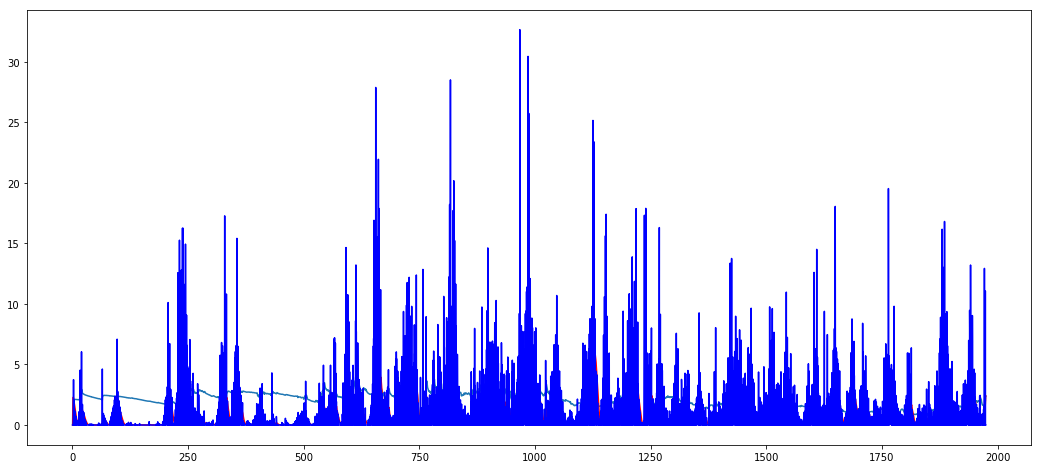

File saved! irb/621/phasic_621.json
File saved! irb/621/smna_621.json
Processed eda data.
USER 722
File not found acc in irb/722
File saved! irb/722/q1_722.json
File saved! irb/722/q2_722.json
File saved! irb/722/q3_722.json
File saved! irb/722/q4_722.json
File saved! irb/722/getting-started_722.json
File saved! irb/722/dealing-with-difficulties_722.json
File saved! irb/722/encountering-difficulties_722.json
File saved! irb/722/failing_722.json
File saved! irb/722/submitting_722.json
File saved! irb/722/succeeding_722.json
1930 1930
1.0 0.0
File saved! irb/722/wire_722.json
1.0 0.0
File saved! irb/722/trim_722.json
1.0 0.0
File saved! irb/722/tinning_722.json
1.0 0.0
File saved! irb/722/fluxing_722.json
1.0 0.0
File saved! irb/722/leg-soldering_722.json
1.0 0.0
File saved! irb/722/led1_722.json
1.0 0.0
File saved! irb/722/tacking_722.json
1.0 0.0
File saved! irb/722/sanity-check_722.json
1.0 0.0
File saved! irb/722/testing_722.json
1.0 0.0
File saved! irb/722/led2_722.json
1.0 0.0
File

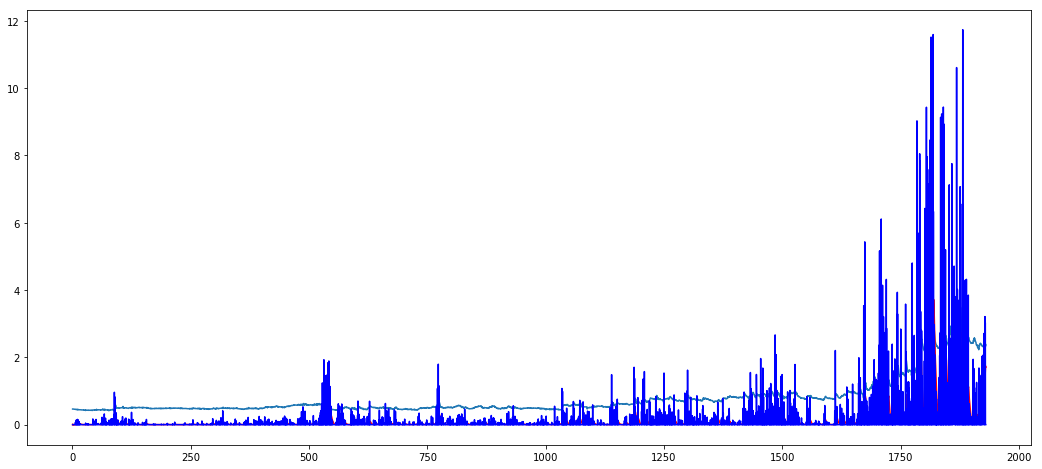

File saved! irb/722/phasic_722.json
File saved! irb/722/smna_722.json
Processed eda data.
USER 521
File not found acc in irb/521
File saved! irb/521/q1_521.json
File saved! irb/521/q2_521.json
File saved! irb/521/q3_521.json
File saved! irb/521/q4_521.json
File saved! irb/521/getting-started_521.json
File saved! irb/521/dealing-with-difficulties_521.json
File saved! irb/521/encountering-difficulties_521.json
File saved! irb/521/failing_521.json
File saved! irb/521/submitting_521.json
File saved! irb/521/succeeding_521.json
1200 1200
1.0 0.0
File saved! irb/521/tinning_521.json
1.0 0.0
File saved! irb/521/leg-soldering_521.json
1.0 0.0
File saved! irb/521/sanity-check_521.json
1.0 0.0
File saved! irb/521/testing_521.json
1.0 0.0
File saved! irb/521/wire_521.json
1.0 0.0
File saved! irb/521/led1_521.json
0.0 0.0
File saved! irb/521/fluxing_521.json
0.0 0.0
File saved! irb/521/tacking_521.json
0.0 0.0
File saved! irb/521/led2_521.json
0.0 0.0
File saved! irb/521/led3_521.json
0.0 0.0
File

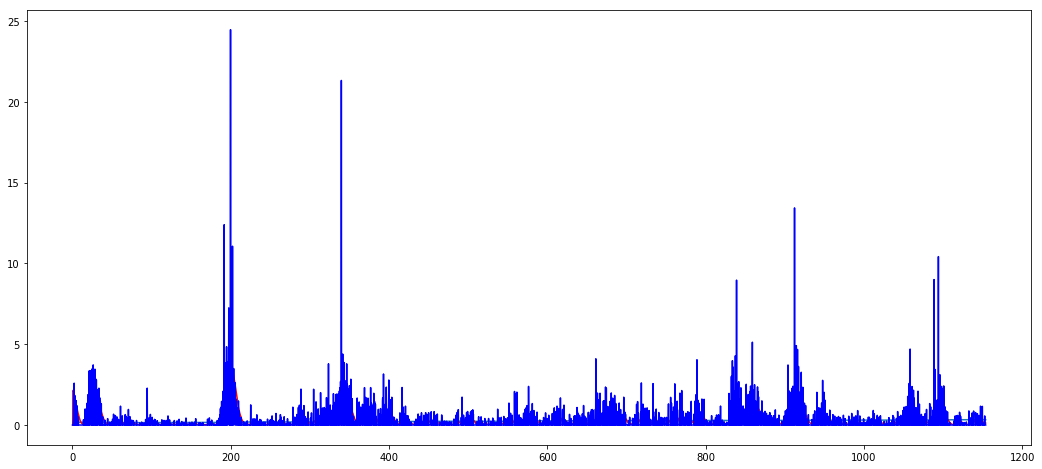

File saved! irb/521/phasic_521.json
File saved! irb/521/smna_521.json
Processed eda data.
USER 1000
File not found acc in irb/1000
ERROR: CODES NOT FOUND
     pcost       dcost       gap    pres   dres
 0: -1.4678e+03 -1.3680e+03  1e+04  1e+02  8e-01
 1: -1.5219e+03 -2.8782e+03  2e+03  2e+01  1e-01
 2: -1.5523e+03 -2.1691e+03  6e+02  5e+00  4e-02
 3: -1.5642e+03 -1.8407e+03  3e+02  2e+00  1e-02
 4: -1.5705e+03 -1.7021e+03  1e+02  7e-01  5e-03
 5: -1.5731e+03 -1.6313e+03  6e+01  3e-01  2e-03
 6: -1.5746e+03 -1.5999e+03  3e+01  9e-02  7e-04
 7: -1.5773e+03 -1.5821e+03  5e+00  8e-03  6e-05
 8: -1.5785e+03 -1.5804e+03  2e+00  3e-03  2e-05
 9: -1.5789e+03 -1.5798e+03  9e-01  5e-04  4e-06
10: -1.5792e+03 -1.5795e+03  3e-01  1e-04  1e-06
11: -1.5793e+03 -1.5793e+03  9e-02  7e-06  5e-08
12: -1.5793e+03 -1.5793e+03  2e-02  1e-06  8e-09
13: -1.5793e+03 -1.5793e+03  4e-03  2e-07  1e-09
14: -1.5793e+03 -1.5793e+03  1e-03  4e-08  3e-10
15: -1.5793e+03 -1.5793e+03  2e-04  6e-09  4e-11
16: -1.5793e+0

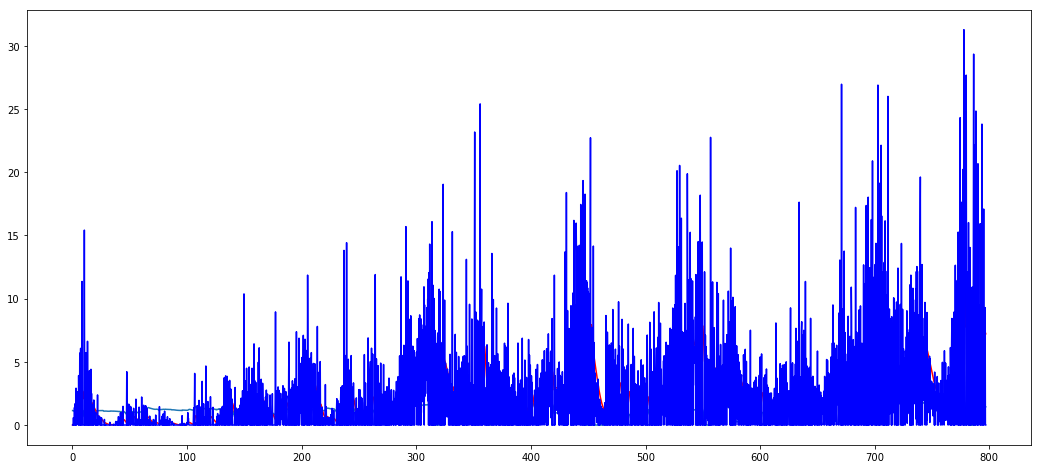

File saved! irb/1000/phasic_1000.json
File saved! irb/1000/smna_1000.json
Processed eda data.
USER 822
File not found acc in irb/822
File saved! irb/822/q1_822.json
File saved! irb/822/q2_822.json
File saved! irb/822/q3_822.json
File saved! irb/822/q4_822.json
File saved! irb/822/getting-started_822.json
File saved! irb/822/dealing-with-difficulties_822.json
File saved! irb/822/encountering-difficulties_822.json
File saved! irb/822/failing_822.json
File saved! irb/822/submitting_822.json
File saved! irb/822/succeeding_822.json
3144 3144
1.0 0.0
File saved! irb/822/tinning_822.json
1.0 0.0
File saved! irb/822/tacking_822.json
1.0 0.0
File saved! irb/822/wire_822.json
1.0 0.0
File saved! irb/822/fluxing_822.json
1.0 0.0
File saved! irb/822/sanity-check_822.json
1.0 0.0
File saved! irb/822/leg-soldering_822.json
1.0 0.0
File saved! irb/822/testing_822.json
1.0 0.0
File saved! irb/822/led1_822.json
1.0 0.0
File saved! irb/822/led2_822.json
1.0 0.0
File saved! irb/822/led3_822.json
1.0 0.0


In [154]:
# %pylab inline
data = filter(os.path.isdir, glob(DATA_ROOT + "/*"))
for folder in data:
    user = os.path.basename(folder)
    if user == "datasets":
        continue
    print("USER", user)
#     save_textchunk(folder)
#     save_notebook_events(folder)
#     save_mouse_events(folder)
    process_acc(folder)
    process_maxqda(folder)
    analyze_eda(folder)